In [15]:
import os
import glob
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style='whitegrid')  # Set seaborn theme

# ===========================
# Load and filter data
# ===========================
base_dir = "analysis/abide"
selected_rois = ['Temporal Region', 'Prefrontal Cortex', 'Cingulate Cortex',
                 'Amygdala', 'Hippocampus', 'Insula', 'Cerebellum']

# Load ROI metrics from CSV files and filter by selected brain regions
def load_and_filter_data(files, group_name, selected_rois=None):
    df_list = []
    for file in files:
        df = pd.read_csv(file)
        df['source_file'] = file
        df['group'] = group_name
        if selected_rois is not None:
            df = df[df['Region'].isin(selected_rois)]
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

# Load ASD and Control subject data
asd_files = glob.glob(os.path.join(base_dir, "*", "patient", "metrics", "abide_roi_metrics.csv"))
asd_data = load_and_filter_data(asd_files, 'ASD', selected_rois)

control_files = glob.glob(os.path.join(base_dir, "*", "control", "metrics", "abide_roi_metrics.csv"))
control_data = load_and_filter_data(control_files, 'Control', selected_rois)

# Merge and clean dataset
all_data = pd.concat([asd_data, control_data], ignore_index=True)
all_data.dropna(inplace=True)

# Extract age bin (e.g., 12_17) from file path
def extract_age_bin(path):
    match = re.search(r"abide[\\/](.*?)[\\/]", path)
    return match.group(1) if match else "unknown"

all_data['age_bin'] = all_data['source_file'].apply(extract_age_bin)
age_bin_order = ["11-", "12_17", "18_25", "25+"]
all_data['age_bin'] = pd.Categorical(all_data['age_bin'], categories=age_bin_order, ordered=True)

In [16]:
# ===========================
# Transform data into wide format per subject
# ===========================
def create_pivot(df):
    subject_ages = df.groupby('SubjectID')['Age'].first()
    subject_bins = df.groupby('SubjectID')['age_bin'].first()
    # Pivot metrics so each row is a subject with metric values across ROIs
    pivot_df = df.pivot_table(index='SubjectID', columns='Region', values=['Closeness', 'Clustering', 'Degree'])
    pivot_df.columns = [f'{metric}_{roi}' for metric, roi in pivot_df.columns]
    pivot_df.reset_index(inplace=True)
    pivot_df['Age'] = pivot_df['SubjectID'].map(subject_ages)
    pivot_df['age_bin'] = pivot_df['SubjectID'].map(subject_bins)
    return pivot_df

# Prepare ASD and Control datasets for modeling
asd_pivot_df = create_pivot(all_data[all_data['group'] == 'ASD']).dropna()
asd_pivot_df['group'] = 'ASD'

control_pivot_df = create_pivot(all_data[all_data['group'] == 'Control']).dropna()
control_pivot_df['group'] = 'Control'

In [17]:
# ===========================
# Train HMM per metric for ASD group
# ===========================
def train_hmm_by_metric(df, metrics, n_states=2, n_seeds=10, prefix='ASD'):
    for metric in metrics:
        print(f"\nTraining HMM on metric: {metric}")

        # Select only columns corresponding to the current metric
        metric_cols = [col for col in df.columns if col.startswith(metric)]
        X = df[metric_cols].values

        # Remove zero-variance features to avoid model issues
        variances = X.var(axis=0)
        X = X[:, variances > 0]

        if X.shape[1] == 0:
            print(f"No valid features for {metric}")
            continue

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Train multiple HMMs with different random seeds, keep best log-likelihood
        best_model = None
        best_score = -np.inf
        for seed in range(n_seeds):
            try:
                model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=400, random_state=seed)
                model.fit(X_scaled)
                score = model.score(X_scaled)
                if not np.isnan(score) and score > best_score:
                    best_model = model
                    best_score = score
            except Exception as e:
                print(f"HMM error (seed {seed}): {e}")

        # Add most likely hidden states as a new column
        if best_model is not None:
            hidden_states = best_model.predict(X_scaled)
            state_col = f"{prefix}_{metric}_state"
            df[state_col] = hidden_states
            print(f"Column '{state_col}' added.")
        else:
            print(f"No valid HMM for {metric}")

# Train HMM on 3 metrics: Closeness, Clustering, Degree
metrics = ['Closeness', 'Clustering', 'Degree']
train_hmm_by_metric(asd_pivot_df, metrics, n_states=3, n_seeds=10, prefix='ASD')


Training HMM on metric: Closeness
Column 'ASD_Closeness_state' added.

Training HMM on metric: Clustering
Column 'ASD_Clustering_state' added.

Training HMM on metric: Degree
Column 'ASD_Degree_state' added.


In [18]:
# ===========================
# Simulate developmental trajectories through HMM states
# ===========================
from collections import Counter

def simulate_trajectories(df, state_column, age_bins, n_bootstraps=1000):
    state_trajectories = []
    for b in range(n_bootstraps):
        trajectory = []
        valid = True
        for bin_label in age_bins:
            candidates = df[df['age_bin'] == bin_label]
            if candidates.empty or state_column not in candidates.columns:
                valid = False
                break
            # Randomly sample one subject per age bin per simulation
            chosen = candidates.sample(n=1, random_state=b)
            state = chosen[state_column].values[0]
            trajectory.append(state)
        if valid:
            state_trajectories.append(tuple(trajectory))
    return state_trajectories

# Run simulations
age_bins = age_bin_order
n_bootstraps = 1000
trajectory_dict = {}

# Simulate and record most common state paths per metric
for metric in metrics:
    state_col = f"ASD_{metric}_state"
    if state_col in asd_pivot_df.columns:
        print(f"\nSimulating trajectories for metric: {metric}")
        trajectories = simulate_trajectories(asd_pivot_df, state_col, age_bins, n_bootstraps=n_bootstraps)
        counts = Counter(trajectories)
        most_common = counts.most_common(5)
        print("Most frequent trajectories:")
        for i, (traj, count) in enumerate(most_common):
            print(f"  {i+1}. {traj} (frequency: {count})")
        trajectory_dict[metric] = trajectories


Simulating trajectories for metric: Closeness
Most frequent trajectories:
  1. (2, 2, 2, 2) (frequency: 210)
  2. (0, 2, 2, 2) (frequency: 163)
  3. (2, 2, 0, 2) (frequency: 92)
  4. (0, 2, 0, 2) (frequency: 78)
  5. (2, 2, 2, 0) (frequency: 76)

Simulating trajectories for metric: Clustering
Most frequent trajectories:
  1. (0, 1, 1, 1) (frequency: 126)
  2. (0, 0, 1, 1) (frequency: 85)
  3. (0, 1, 0, 1) (frequency: 79)
  4. (1, 1, 1, 1) (frequency: 70)
  5. (0, 0, 0, 1) (frequency: 58)

Simulating trajectories for metric: Degree
Most frequent trajectories:
  1. (0, 2, 2, 2) (frequency: 116)
  2. (0, 0, 2, 2) (frequency: 90)
  3. (0, 2, 0, 2) (frequency: 60)
  4. (0, 0, 0, 2) (frequency: 56)
  5. (2, 2, 2, 2) (frequency: 43)



HMM transitions - metric: Closeness


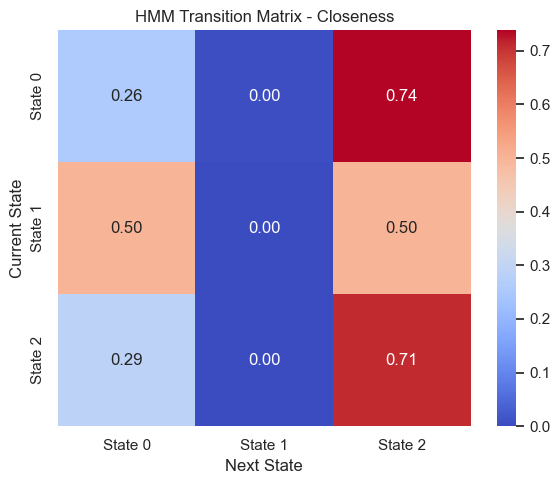


HMM transitions - metric: Clustering


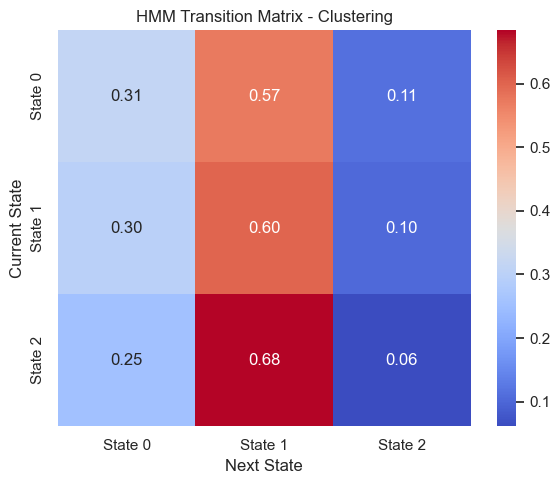


HMM transitions - metric: Degree


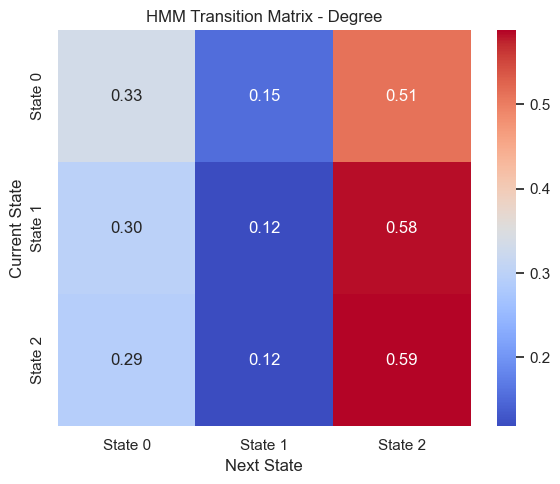

In [19]:
# ===========================
# Plot transition matrices from simulated trajectories
# ===========================
for metric, trajectories in trajectory_dict.items():
    print(f"\nHMM transitions - metric: {metric}")
    n_states = 3
    transition_counts = np.zeros((n_states, n_states), dtype=int)

    # Count transitions from one state to the next across all simulated trajectories
    for traj in trajectories:
        for (s1, s2) in zip(traj[:-1], traj[1:]):
            transition_counts[s1, s2] += 1

    # Normalize to get probabilities
    transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

    # Plot heatmap of transition probabilities
    plt.figure(figsize=(6, 5))
    sns.heatmap(transition_probs, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=[f'State {i}' for i in range(n_states)],
                yticklabels=[f'State {i}' for i in range(n_states)])
    plt.title(f"HMM Transition Matrix - {metric}")
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.tight_layout()
    plt.show()